# ISA 444 Project

Madison Banks, Dan Claypool, Connor Oviatt

## Install Packages and Libraries

In [3]:
!pip install utilsforecast statsforecast mlforecast timegpt neuralforecast

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape
from utilsforecast.plotting import plot_series
from coreforecast.differences import num_diffs, num_seas_diffs
from statsforecast import StatsForecast
from statsforecast.models import(Naive, SeasonalNaive, AutoETS, AutoARIMA )

from neuralforecast.auto import AutoNBEATS, AutoNHITS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.2/263.2 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.8/899.8 MB 800.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 241.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 954.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Read in Data

In [6]:
import pandas as pd

df = (
    pd.read_parquet('/work/sample_hotels (3).parquet')
    .assign(
        ds = lambda x: pd.to_datetime(x['ds']),
        y = lambda x: x['y'].astype(float),
        day = lambda x: pd.to_datetime(x['ds']).dt.day,
        month = lambda x: pd.to_datetime(x['ds']).dt.month,
        year = lambda x: pd.to_datetime(x['ds']).dt.year,
    )
)

(df.info())

display(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 10172 entries, 1430 to 298041
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   unique_id      10172 non-null  object        
 1   ds             10172 non-null  datetime64[us]
 2   holiday_flag   10172 non-null  object        
 3   target_day     10172 non-null  object        
 4   target_month   10172 non-null  object        
 5   target_year    10172 non-null  int32         
 6   location_type  10172 non-null  object        
 7   hotel_type     10172 non-null  object        
 8   y              10172 non-null  float64       
 9   otb_1          10172 non-null  float64       
 10  otb_2          10172 non-null  float64       
 11  otb_3          10172 non-null  float64       
 12  otb_4          10172 non-null  float64       
 13  otb_5          10172 non-null  float64       
 14  otb_6          10172 non-null  float64       
 15  otb_7          10172

,unique_id,ds,holiday_flag,target_day,target_month,target_year,location_type,hotel_type,y,otb_1,...,otb_54,otb_55,otb_56,otb_57,otb_58,otb_59,otb_60,day,month,year
1430,hotel_0,2022-01-01,no,Sat,Jan,2022,NonSuburban,Resorts & Destinations,0.975309,0.679012,...,0.185185,0.160494,0.160494,0.160494,0.160494,0.160494,0.160494,1,1,2022
1431,hotel_0,2022-01-02,no,Sun,Jan,2022,NonSuburban,Resorts & Destinations,0.493827,0.308642,...,0.074074,0.074074,0.061728,0.061728,0.061728,0.061728,0.049383,2,1,2022
1432,hotel_0,2022-01-03,no,Mon,Jan,2022,NonSuburban,Resorts & Destinations,0.456790,0.358025,...,0.024691,0.024691,0.024691,0.024691,0.024691,0.024691,0.024691,3,1,2022
1433,hotel_0,2022-01-04,no,Tue,Jan,2022,NonSuburban,Resorts & Destinations,0.592593,0.419753,...,0.074074,0.061728,0.061728,0.037037,0.037037,0.024691,0.024691,4,1,2022
1434,hotel_0,2022-01-05,no,Wed,Jan,2022,NonSuburban,Resorts & Destinations,0.530864,0.407407,...,0.074074,0.074074,0.049383,0.049383,0.024691,0.024691,0.012346,5,1,2022


## Import Nixtla

In [9]:
from nixtla import NixtlaClient

nixtla_client = NixtlaClient(api_key = "nixak-eX92lSIatoWxvaVDNG4v7IFJQ5cva8FrMRaNuADzsiAlt007Tm8ejGc7VUU0MJEt2YZtsa2CmsfcbYPg")

## Choose Models

In [13]:
from mlforecast import MLForecast
from lightgbm import LGBMRegressor  
from xgboost import XGBRegressor
from mlforecast.utils import PredictionIntervals
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive, Naive, AutoETS, AutoARIMA



# 1. StatsForecast models
stats_models = [
    SeasonalNaive(season_length=7),
    Naive(),
    AutoETS(season_length=7),
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models=stats_models, freq='D')

# 2. MLForecast models
ml_models = [
    XGBRegressor(random_state=0, n_estimators=100),
    LGBMRegressor(random_state=0, n_estimators=100)  # Now using correct import
]

mlf = MLForecast(
    models=ml_models,
    freq='D',
    lags=[1, 7, 14, 28],
    date_features=['dayofweek', 'month']
)

# 3. NeuralForecast models
neural_models = [
    NBEATS(h=28, input_size=56, max_steps=100),
    NHITS(h=28, input_size=56, max_steps=100)
]

nf = NeuralForecast(models=neural_models, freq='D')




Seed set to 1
Seed set to 1


In [14]:
!pip install timecopilot==0.0.22

  Using cached openai-2.9.0-py3-none-any.whl.metadata (29 kB)
  Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.5 kB)
  Using cached pydantic_ai-1.27.0-py3-none-any.whl.metadata (14 kB)
  Using cached tabpfn_time_series-1.0.3-py3-none-any.whl.metadata (4.9 kB)
  Using cached timecopilot_chronos_forecasting-0.2.0-py3-none-any.whl.metadata (23 kB)
  Using cached timecopilot_granite_tsfm-0.1.1-py3-none-any.whl.metadata (18 kB)
  Using cached timecopilot_timesfm-0.2.1-py3-none-any.whl.metadata (4.5 kB)
  Using cached timecopilot_tirex-0.1.0-py3-none-any.whl.metadata (16 kB)
  Using cached timecopilot_toto-0.1.3-py3-none-any.whl.metadata (1.1 kB)
  Using cached timecopilot_uni2ts-0.1.2-py3-none-any.whl.metadata (30 kB)
  Using cached transformers-4.40.1-py3-none-any.whl.metadata (137 kB)
  Using cached tsfeatures-0.4.5-py3-none-any.whl.metadata (7.4 kB)
  Using cached datasets-4.4.1-py3-none-any.whl.metadata (19 kB)
  Using cached python_dotenv

## Convert String Data to Numeric

In [12]:
# Convert string data to numeric
df_clean = df.copy()

# Convert specific columns that have clear numeric mappings
string_to_numeric = {
    # Days of week
    'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7,
    # Months
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12,
    # Boolean flags
    'no': 0, 'yes': 1
}

columns_to_convert = ['target_day', 'target_month', 'holiday_flag']

for col in columns_to_convert:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].replace(string_to_numeric)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')


import pandas as pd

# Convert to categorical then one-hot encode
df_encoded = (pd.get_dummies(df_clean, 
                           columns=['location_type', 'hotel_type'],
                           drop_first=True,  # Avoids multicollinearity
                           dtype=int)
)

# Check the cleaned data
print("\nCleaned data sample:")
print(df_encoded.head())


Cleaned data sample:
     unique_id         ds  holiday_flag  target_day  target_month  \
1430   hotel_0 2022-01-01             0           6             1   
1431   hotel_0 2022-01-02             0           7             1   
1432   hotel_0 2022-01-03             0           1             1   
1433   hotel_0 2022-01-04             0           2             1   
1434   hotel_0 2022-01-05             0           3             1   

      target_year         y     otb_1     otb_2     otb_3  ...    otb_58  \
1430         2022  0.975309  0.679012  0.604938  0.555556  ...  0.160494   
1431         2022  0.493827  0.308642  0.320988  0.296296  ...  0.061728   
1432         2022  0.456790  0.358025  0.308642  0.296296  ...  0.024691   
1433         2022  0.592593  0.419753  0.407407  0.358025  ...  0.037037   
1434         2022  0.530864  0.407407  0.395062  0.419753  ...  0.024691   

        otb_59    otb_60  day  month  year  location_type_NonSuburban  \
1430  0.160494  0.160494    1    

## Run Cross-Validation Models

In [ ]:
# 2. MLForecast models (
ml_models = [
    XGBRegressor(random_state=0, n_estimators=100),
    LGBMRegressor(random_state=0, n_estimators=100)
]

mlf = MLForecast(
    models=ml_models,
    freq='D',
    lags=[1, 7, 14, 28]
)

print("Running cross-validation for statistical models...")
cross_df_stats = sf.cross_validation(
    h=28,
    df=df_encoded[['ds', 'unique_id', 'y']],  # Changed from df to df_clean
    n_windows=5,
    step_size=28
)

print("Running cross-validation for ML models...")
cross_df_ml = mlf.cross_validation(
    df=df_encoded[['ds', 'unique_id', 'y']],  # Changed from df to df_clean
    h=28,
    n_windows=5,
    step_size=28
)

print("Running cross-validation for neural models...")
cross_df_neural = nf.cross_validation(
    df=df_encoded,  # Changed from df to df_clean
    h=28,
    n_windows=5,
    step_size=28
)

Running cross-validation for statistical models...


## Save Models

In [22]:
# Save each dataframe to a CSV file
cross_df_neural.to_csv('cross_df_neural.csv', index=False)
cross_df_ml.to_csv('cross_df_ml.csv', index=False)
cross_df_stats.to_csv('cross_df_stats.csv', index=False)

NameError: name 'cross_df_neural' is not defined

## Fill in Missing Dates

In [36]:

df_clean = []

for hotel_id in df_encoded['unique_id'].unique():
    hotel_data = (df_encoded[df_encoded['unique_id'] == hotel_id]
                           .sort_values('ds')
                           .reset_index(drop=True)
                 )

    # Create complete date range for this hotel
    full_date_range = pd.date_range(start=hotel_data['ds'].min(),
                                   end=hotel_data['ds'].max(),
                                   freq='D')

    # Reindex to fill missing dates
    hotel_complete = (hotel_data.set_index('ds')
                               .reindex(full_date_range)
                               .reset_index()
                               .rename(columns={'index': 'ds'})
                     )

    # Fill the unique_id for new rows
    hotel_complete['unique_id'] = hotel_id

    # Fill missing target values using modern syntax
    hotel_complete['y'] = hotel_complete['y'].ffill()  # Forward fill

    df_clean.append(hotel_complete)

# Combine all cleaned hotel data
df_final = pd.concat(df_clean, ignore_index=True)



INFO:nixtla.nixtla_client:Validating inputs...
/root/venv/lib/python3.11/site-packages/nixtla/nixtla_client.py:407: UserWarning: `df` contains the following exogenous features: ['holiday_flag', 'target_day', 'target_month', 'target_year', 'otb_1', 'otb_2', 'otb_3', 'otb_4', 'otb_5', 'otb_6', 'otb_7', 'otb_8', 'otb_9', 'otb_10', 'otb_11', 'otb_12', 'otb_13', 'otb_14', 'otb_15', 'otb_16', 'otb_17', 'otb_18', 'otb_19', 'otb_20', 'otb_21', 'otb_22', 'otb_23', 'otb_24', 'otb_25', 'otb_26', 'otb_27', 'otb_28', 'otb_29', 'otb_30', 'otb_31', 'otb_32', 'otb_33', 'otb_34', 'otb_35', 'otb_36', 'otb_37', 'otb_38', 'otb_39', 'otb_40', 'otb_41', 'otb_42', 'otb_43', 'otb_44', 'otb_45', 'otb_46', 'otb_47', 'otb_48', 'otb_49', 'otb_50', 'otb_51', 'otb_52', 'otb_53', 'otb_54', 'otb_55', 'otb_56', 'otb_57', 'otb_58', 'otb_59', 'otb_60', 'day', 'month', 'year', 'location_type_NonSuburban', 'hotel_type_Key Central Business District', 'hotel_type_Other High Leisure Mix', 'hotel_type_Resorts & Destinations']

## Run TimeGPT

In [80]:
# Time series cross-validation with TimeGPT
timegpt_cv_results = nixtla_client.cross_validation(
    df=df_final,
    h=28,           # forecast horizon (same as your main forecast)
    step_size=7,    # how many periods to move forward each fold
    n_windows=5,    # number of validation windows
    freq='D'
)



INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['holiday_flag', 'target_day', 'target_month', 'target_year', 'otb_1', 'otb_2', 'otb_3', 'otb_4', 'otb_5', 'otb_6', 'otb_7', 'otb_8', 'otb_9', 'otb_10', 'otb_11', 'otb_12', 'otb_13', 'otb_14', 'otb_15', 'otb_16', 'otb_17', 'otb_18', 'otb_19', 'otb_20', 'otb_21', 'otb_22', 'otb_23', 'otb_24', 'otb_25', 'otb_26', 'otb_27', 'otb_28', 'otb_29', 'otb_30', 'otb_31', 'otb_32', 'otb_33', 'otb_34', 'otb_35', 'otb_36', 'otb_37', 'otb_38', 'otb_39', 'otb_40', 'otb_41', 'otb_42', 'otb_43', 'otb_44', 'otb_45', 'otb_46', 'otb_47', 'otb_48', 'otb_49', 'otb_50', 'otb_51', 'otb_52', 'otb_53', 'otb_54', 'otb_55', 'otb_56', 'otb_57', 'otb_58', 'otb_59', 'otb_60', 'day', 'month', 'year', 'location_type_NonSuburban', 'hotel_type_Key Central Business District', 'hotel_type_Other High Leisure Mix', 'hotel_type_Resorts & Destinations']
INFO:nixtla.nixt

In [83]:
timegpt_cv_results.to_csv('timegpt_results.csv', index=False)

In [15]:

cross_df_timegpt = pd.read_csv('/work/timegpt_results.csv')
cross_df_neural = pd.read_csv('/work/cross_df_neural.csv')
cross_df_ml = pd.read_csv('/work/cross_df_ml.csv')
cross_df_stats = pd.read_csv('/work/cross_df_stats.csv')


## Evaluate

In [18]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape

# First, merge all your cross-validation dataframes horizontally
combined_cross_df = (
    cross_df_stats
    .merge(cross_df_ml, on=['unique_id', 'ds', 'cutoff', 'y'], how='outer')
    .merge(cross_df_neural, on=['unique_id', 'ds', 'cutoff', 'y'], how='outer')
    .merge(cross_df_timegpt, on=['unique_id', 'ds', 'cutoff', 'y'], how='outer')
)

# Then evaluate all models at once
evaluation_df = evaluate(
    df=combined_cross_df,
    metrics=[mae, mape, rmse],
    models=combined_cross_df.columns[4:].tolist()  # All model columns after the first 4
)


evaluation_df

,unique_id,cutoff,metric,SeasonalNaive,Naive,AutoETS,AutoARIMA,XGBRegressor,LGBMRegressor,NBEATS,NHITS,TimeGPT
0,hotel_77,2022-07-23,mae,0.000439,0.000439,0.007625,0.001613,NaN,NaN,0.005815,0.002671,NaN
1,hotel_77,2022-08-08,mae,NaN,NaN,NaN,NaN,0.002352,0.003643,NaN,NaN,NaN
2,hotel_77,2022-08-20,mae,0.001130,0.001130,0.002973,0.001463,NaN,NaN,0.007925,0.004121,NaN
3,hotel_77,2022-09-05,mae,NaN,NaN,NaN,NaN,0.001298,0.004481,NaN,NaN,NaN
4,hotel_77,2022-09-17,mae,0.001946,0.002071,0.006683,0.001991,NaN,NaN,0.008068,0.004527,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
466,hotel_7,2023-06-02,rmse,0.247232,0.326730,0.227589,0.141016,0.260538,0.275490,0.188801,0.193128,0.068540
467,hotel_70,2023-06-02,rmse,0.218625,0.110830,0.140214,0.067309,0.147967,0.147888,0.226847,0.212493,0.185741
468,hotel_84,2023-06-02,rmse,0.180628,0.115286,0.143202,0.122648,0.109904,0.103308,0.115288,0.118391,0.052554
469,hotel_91,2023-06-02,rmse,0.178832,0.103525,0.073276,0.091542,0.107800,0.089758,0.070343,0.086832,0.053382


## Store Evaluation Results

In [51]:
evaluation_df.to_csv("evaluation_results.csv", index= False)

## Find the model that was the winner most often

In [21]:
# First, let's see the best model for each unique_id and metric combination
model_columns = ['SeasonalNaive', 'Naive', 'AutoETS', 'AutoARIMA', 
                'XGBRegressor', 'LGBMRegressor', 'NHITS', 'TimeGPT']

evaluation_with_winners = (
    evaluation_df
    .assign(best_model = lambda x: x[model_columns].idxmin(axis=1))
)

# Count wins by metric
wins_by_metric = (
    evaluation_with_winners
    .groupby(['metric', 'best_model'])
    .size()
    .reset_index(name='wins')
    .pivot(index='metric', columns='best_model', values='wins')
    .fillna(0)
)

display(wins_by_metric)

/tmp/ipykernel_118/1352810510.py:7: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .assign(best_model = lambda x: x[model_columns].idxmin(axis=1))


best_model,AutoARIMA,AutoETS,LGBMRegressor,NHITS,Naive,SeasonalNaive,TimeGPT,XGBRegressor
metric,,,,,,,,
mae,13,9,6,11,10,11,85,12
mape,11,14,2,13,9,8,82,8
rmse,15,13,5,11,8,8,86,11


In [39]:

# Now run the forecast with filled data
timegpt_forecast = nixtla_client.forecast(
    df=df_final[['unique_id', 'ds', 'y']], 
    h=28,
    freq='D'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [ ]:
!pip install statsforecast.plotting

Forecast columns: ['unique_id', 'ds', 'TimeGPT']
Sample forecast data:
  unique_id         ds   TimeGPT
0   hotel_0 2023-07-01  0.827481
1   hotel_0 2023-07-02  0.624427
2   hotel_0 2023-07-03  0.635184
3   hotel_0 2023-07-04  0.732741
4   hotel_0 2023-07-05  0.741329


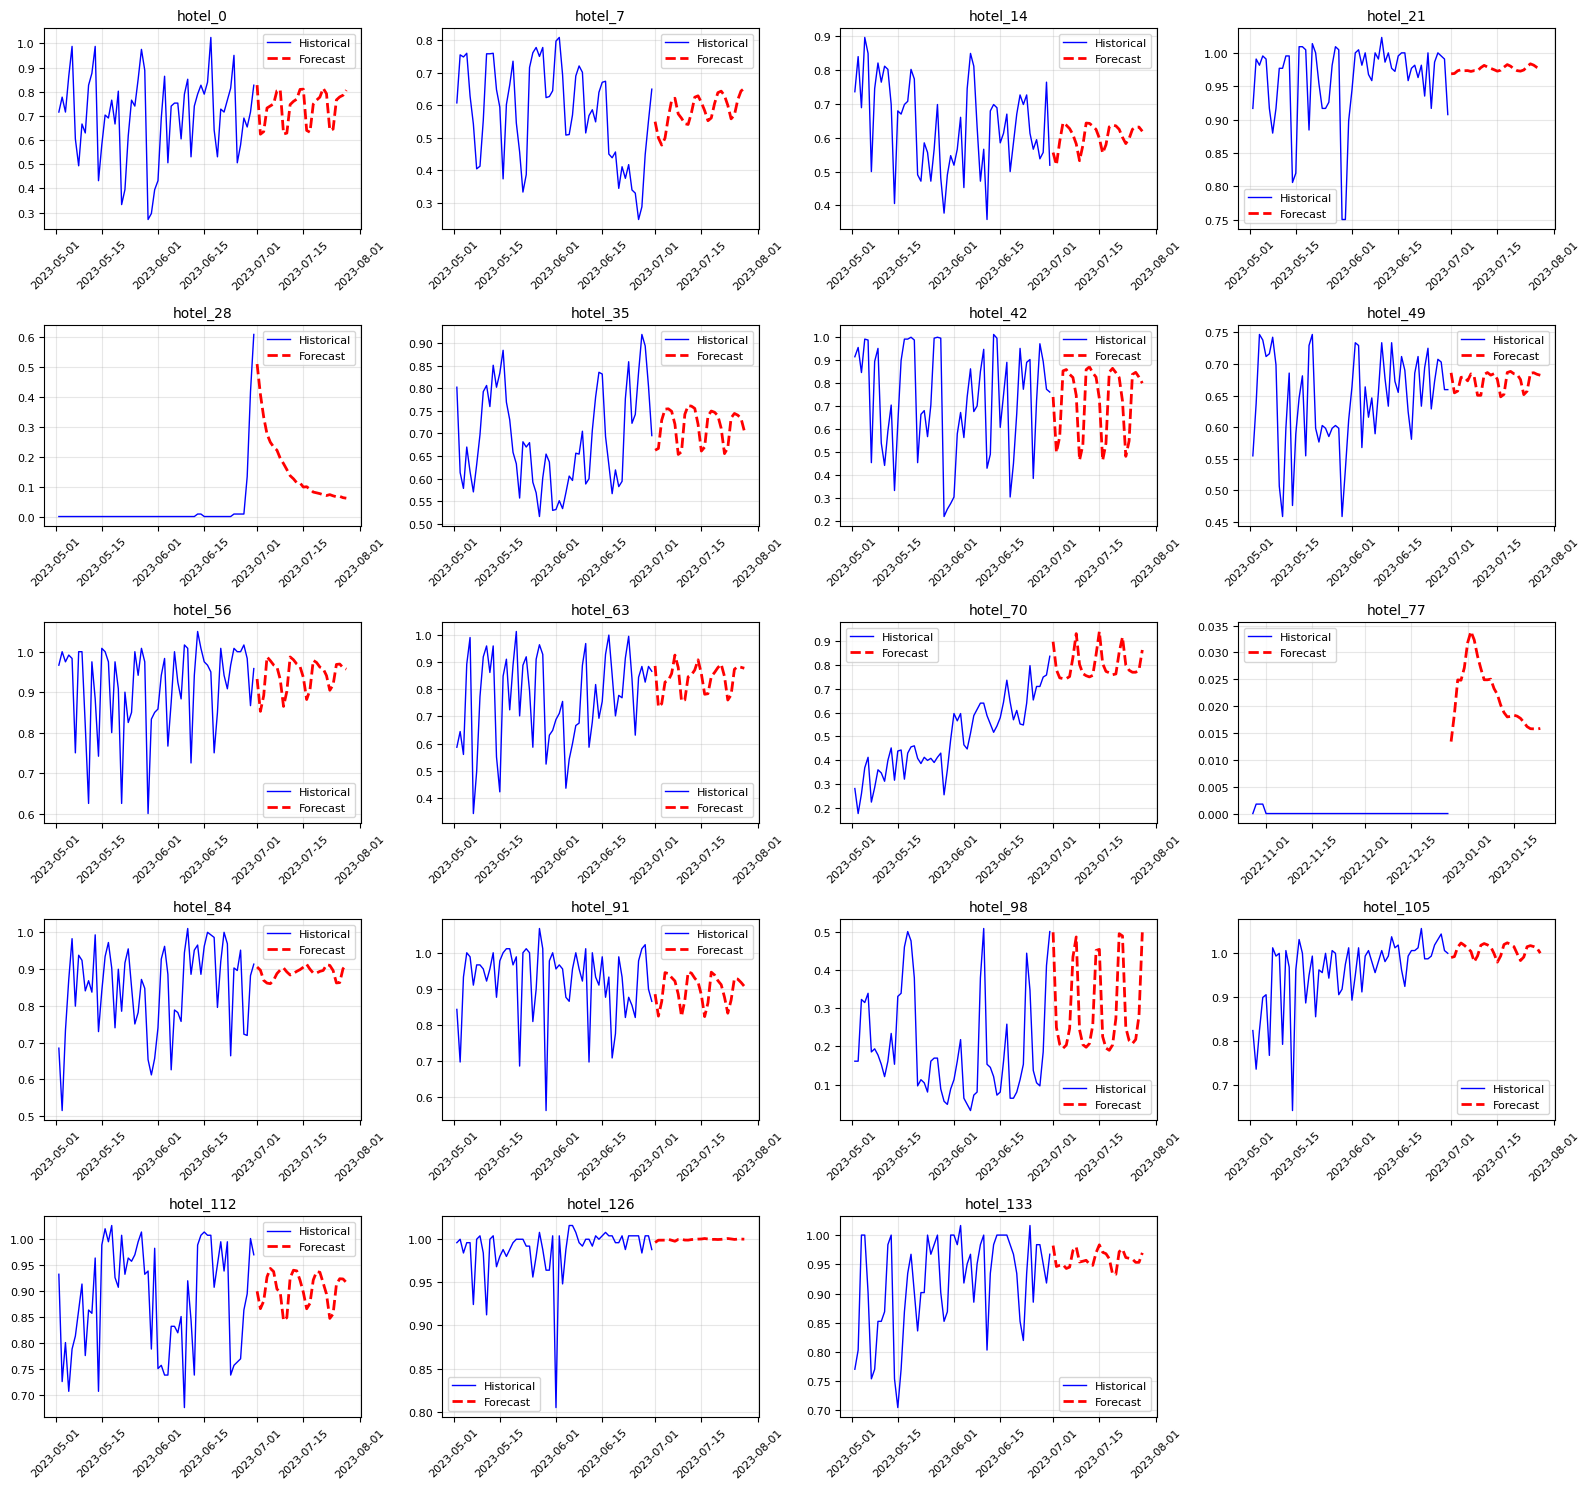


Forecast Summary:
Number of hotels: 19
Forecast horizon: 28 days
Forecast column used: TimeGPT


In [45]:
import matplotlib.pyplot as plt
import numpy as np

# timegpt_forecast is already the forecast result, no need to call .predict()
forecast = timegpt_forecast

# Check what columns are in the forecast
print("Forecast columns:", forecast.columns.tolist())
print("Sample forecast data:")
print(forecast.head())

# Get all hotels from the filled dataframe
all_hotels = df_final['unique_id'].unique()

# Create subplots (4 columns)
n_cols = 4
n_rows = (len(all_hotels) + n_cols - 1) // n_cols  # Better calculation for rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3*n_rows))

# Handle case where there's only one row
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Plot each hotel
for i, hotel_id in enumerate(all_hotels):
    # Get historical data (last 60 days)
    hotel_data = df_final[df_final['unique_id'] == hotel_id].tail(60)

    # Get forecast data for this hotel
    hotel_forecast = forecast[forecast['unique_id'] == hotel_id]

    # Plot historical data
    axes[i].plot(hotel_data['ds'], hotel_data['y'], 
                label='Historical', color='blue', linewidth=1)

    # Plot forecast - check if 'TimeGPT' column exists, otherwise use the prediction column
    if 'TimeGPT' in hotel_forecast.columns:
        forecast_col = 'TimeGPT'
    elif 'y' in hotel_forecast.columns:
        forecast_col = 'y'
    else:
        # Find the prediction column (usually the last column that's not unique_id or ds)
        forecast_col = [col for col in hotel_forecast.columns 
                       if col not in ['unique_id', 'ds']][-1]

    axes[i].plot(hotel_forecast['ds'], hotel_forecast[forecast_col], 
                label='Forecast', linestyle='--', color='red', linewidth=2)

    axes[i].set_title(hotel_id, fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)
    axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for i in range(len(all_hotels), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Print some summary statistics
print(f"\nForecast Summary:")
print(f"Number of hotels: {len(all_hotels)}")
print(f"Forecast horizon: {len(hotel_forecast)} days")
print(f"Forecast column used: {forecast_col}")